## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("dataset/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
#del df_comp['spx']
#del df_comp['dax']
#del df_comp['ftse']
#del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## ARIMA(1,1,1)

In [8]:
# it's more similar to a return model, because the integrated part is to transform the underlying data
model_111 = ARIMA(df.market_value, order=(1,1,1))
result_111 = model_111.fit()
result_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Wed, 10 Mar 2021   AIC                          55215.333
Time:                        20:00:08   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.651      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.377      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

## Residuals of the ARIMA(1,1,1)

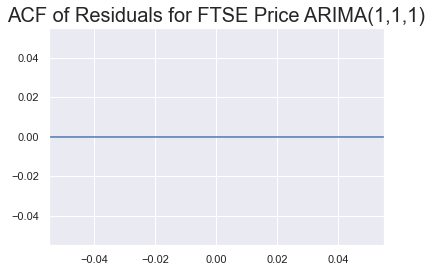

In [9]:
# it's more similar to a return model, because the integrated part is to transform the underlying data
# this is wrong because there's missing value, and as it's monitoring the delta, there's no value for the first day
df['residual'] = result_111.resid
sgt.plot_acf(df.residual, zero=False, lags=40)
plt.title('ACF of Residuals for FTSE Price ARIMA(1,1,1)', size=20)
plt.show()

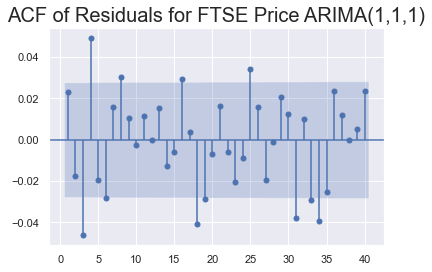

In [11]:
# 3rd and 4th lags are highly significant
df['residual'] = result_111.resid
sgt.plot_acf(df.residual[1:], zero=False, lags=40)
plt.title('ACF of Residuals for FTSE Price ARIMA(1,1,1)', size=20)
plt.show()

## Higher-Lag ARIMA Models

In [13]:
model_112 = ARIMA(df.market_value, order=(1,1,2))
result_112 = model_112.fit()
model_113 = ARIMA(df.market_value, order=(1,1,3))
result_113 = model_113.fit()
model_211 = ARIMA(df.market_value, order=(2,1,1))
result_211 = model_211.fit()
model_311 = ARIMA(df.market_value, order=(3,1,1))
result_311 = model_311.fit()
model_312 = ARIMA(df.market_value, order=(3,1,2))
result_312 = model_312.fit(start_ar_lags=7)

In [14]:
# ARIMA(1,1,3) is the best one out of the 6 models
print('ARIMA(1,1,1):', str(result_111.llf), str(result_111.aic))
print('ARIMA(1,1,2):', str(result_112.llf), str(result_112.aic))
print('ARIMA(1,1,3):', str(result_113.llf), str(result_113.aic))
print('ARIMA(2,1,1):', str(result_211.llf), str(result_211.aic))
print('ARIMA(3,1,1):', str(result_311.llf), str(result_311.aic))
print('ARIMA(3,1,2):', str(result_312.llf), str(result_312.aic))

ARIMA(1,1,1): -27603.666412770956 55215.33282554191
ARIMA(1,1,2): -27600.081863116127 55210.163726232255
ARIMA(1,1,3): -27590.424032546976 55192.84806509395
ARIMA(2,1,1): -27599.8074878554 55209.6149757108
ARIMA(3,1,1): -27592.055371704337 55196.11074340867
ARIMA(3,1,2): -27590.660808974728 55195.321617949456


In [15]:
print('LLR Test with p-value:' , str(LLR_test(model_112, model_113)))

LLR Test with p-value: 0.0


In [16]:
print('LLR Test with p-value:' , str(LLR_test(model_111, model_113, DF=2)))

LLR Test with p-value: 0.0


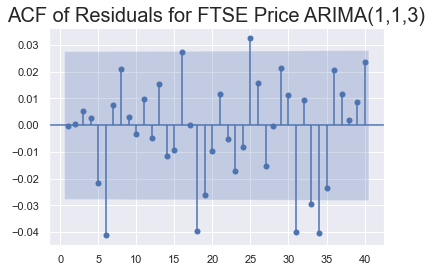

In [17]:
# the 6th lags is quite significant, there must be more sophisicated model doing better job
# we need to examine from ARIMA(1,1,1) to ARIMA(6,1,6)
df['residual2'] = result_113.resid
sgt.plot_acf(df.residual2[1:], zero=False, lags=40)
plt.title('ACF of Residuals for FTSE Price ARIMA(1,1,3)', size=20)
plt.show()

In [18]:
model_511 = ARIMA(df.market_value, order=(5,1,1))
result_511 = model_511.fit(start_ar_lags=7)
model_613 = ARIMA(df.market_value, order=(6,1,3))
result_613 = model_613.fit(start_ar_lags=9)

In [19]:
# ARIMA(6,1,3) is the best
print('ARIMA(1,1,3):', str(result_113.llf), str(result_113.aic))
print('ARIMA(5,1,1):', str(result_511.llf), str(result_511.aic))
print('ARIMA(6,1,3):', str(result_613.llf), str(result_613.aic))

ARIMA(1,1,3): -27590.424032546976 55192.84806509395
ARIMA(5,1,1): -27586.511889870908 55189.023779741816
ARIMA(6,1,3): -27581.45547817454 55184.91095634908


In [20]:
# if you experience error with LLR test, you should go back to your modeling part and increase the start_ar_lags 
print('LLR Test with p-value:' , str(LLR_test(model_113, model_613, DF=5)))

LLR Test with p-value: 0.018


In [21]:
# we would choose ARIMA(5,1,1)
print('LLR Test with p-value:' , str(LLR_test(model_511, model_613, DF=3)))

LLR Test with p-value: 0.117


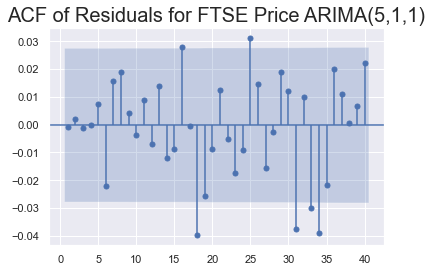

In [22]:
# for the first 15th lags there're no relationship, which is great
df['residual3'] = result_511.resid
sgt.plot_acf(df.residual3[1:], zero=False, lags=40)
plt.title('ACF of Residuals for FTSE Price ARIMA(5,1,1)', size=20)
plt.show()

## Models with Higher Levels of Integration

In [24]:
# if we want to test if the delta we compute here is correct, simply run ARMA(1,1) on this new data
df['delta_prices'] = df.market_value.diff(1)

In [25]:
# we find that it's the same model as the ARIMA(1,1,1) on the market_value column
model_101 = ARIMA(df.delta_prices[1:], order=(1,0,1))
result_101 = model_101.fit()
result_101.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Wed, 10 Mar 2021   AIC                          55215.333
Time:                        20:34:22   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.delta_prices     0.7475      0.070     10.651      0.000       0.610       0.885
ma.L1.delta_prices    -0.7936      0.064    -12.377      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

In [26]:
# our 1st integration layer is stationary, no need to introduce 2nd level
sts.adfuller(df.delta_prices[1:])

(-32.24409349570748,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54845.96104221891)

In [28]:
# if you still want ot test it out
model_121 = ARIMA(df.market_value, order=(1,2,1))
result_121 = model_121.fit(start_ar_lags=4)
result_121.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.market_value   No. Observations:                 5019
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -27614.159
Method:                       css-mle   S.D. of innovations             59.273
Date:                Wed, 10 Mar 2021   AIC                          55236.318
Time:                        20:38:39   BIC                          55262.402
Sample:                    01-11-1994   HQIC                         55245.458
                         - 04-05-2013                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0001      0.001     -0.194      0.846      -0.001       0.001
ar.L1.D2.market_value    -0.0179      0.014     -1.269      0.204      -0.046       0.010
ma.L1.D2.market_value    -1.0000      0.001  -1713.470      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -55.8131           +0.0000j           55.8131            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

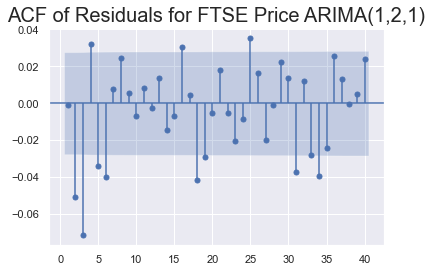

In [30]:
df['residual4'] = result_121.resid
sgt.plot_acf(df.residual4[2:], zero=False, lags=40)
plt.title('ACF of Residuals for FTSE Price ARIMA(1,2,1)', size=20)
plt.show()

## ARIMAX 

In [32]:
# choose S&P price for example as the exogenous variable
model_111x = ARIMA(df.market_value, exog=df.spx, order=(1,1,1))
result_111x = model_111x.fit()
result_111x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.556
Method:                       css-mle   S.D. of innovations             59.132
Date:                Wed, 10 Mar 2021   AIC                          55217.112
Time:                        20:55:47   BIC                          55249.718
Sample:                    01-10-1994   HQIC                         55228.538
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5855      2.655     -0.221      0.825      -5.790       4.619
spx                      0.0011      0.002      0.450      0.653      -0.004       0.006
ar.L1.D.market_value     0.7455      0.070     10.575      0.000       0.607       0.884
ma.L1.D.market_value    -0.7916      0.065    -12.270      0.000      -0.918      -0.665
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3413           +0.0000j            1.3413            0.0000
MA.1            1.2633           +0.0000j            1.2633            0.0000
-----------------------------------------------------------------------------
"""

## SARIMAX

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [34]:
model_s101x = SARIMAX(df.market_value, exog=df.spx, order=(1,0,1), seasonal_order=(2,0,1,5))
result_s101x = model_s101x.fit()
result_s101x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.713
Date:                           Wed, 10 Mar 2021   AIC                          53439.427
Time:                                   21:09:49   BIC                          53485.077
Sample:                               01-07-1994   HQIC                         53455.423
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7030      0.035     76.570      0.000       2.634       2.772
ar.L1          0.9998      0.000   2069.070      0.000       0.999       1.001
ma.L1         -0.3104      0.009    -32.758      0.000      -0.329      -0.292
ar.S.L5        0.9663      0.011     90.945      0.000       0.945       0.987
ar.S.L10       0.0333      0.010      3.401      0.001       0.014       0.052
ma.S.L5       -0.9986      0.006   -179.197      0.000      -1.010      -0.988
sigma2      2439.6443     28.332     86.110      0.000    2384.115    2495.174
===================================================================================
Ljung-Box (Q):                       95.49   Jarque-Bera (JB):              4213.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""